# **Audio Style Transfer Final Project**

# Single-Speaker TTS

### imports

In [1]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa docopt
apt-get update
apt-get install -y libsndfile1
git clone https://github.com/NVIDIA/tacotron2
sed -i 's/from distributed import/from tacotron2.distributed import/g' "/content/tacotron2/train.py"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=c66c7e9856ea175afa7c0577bc6c8ebcb039ef9e9e85258499fa3bb7eed6f15b
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InR

Cloning into 'tacotron2'...


In [2]:
import sys
sys.path.append('tacotron2/')

In [3]:
import torch
import tensorflow as tf
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd
from IPython.display import Audio
import numpy as np
from layers import TacotronSTFT
from audio_processing import griffin_lim
import librosa.display

## Tacotron2 Model + Griffin Lim Vocoder

### Hyperparameters

In [4]:
class HParams:
        def __init__(self):
          self.sampling_rate=22050
          self.filter_length=1024
          self.hop_length=256
          self.win_length=1024

hparams = HParams()

### Text Input

In [5]:
text = "I am a computer but sound just like a human."

### Tacotron2 Model - Text to Mel-spectogram

Block diagram of the Tacotron 2 system architecture

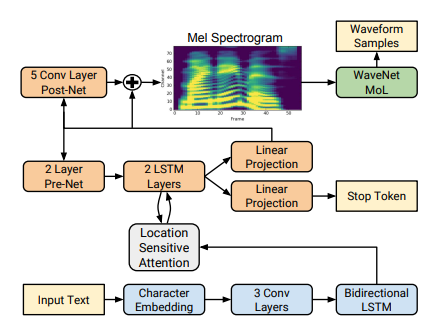

In [4]:
from IPython.display import Image
Image(filename='/content/tacotron2_architecture.PNG')

Load the Tacotron2 model pre-trained on LJ Speech dataset and prepare it for inference:

In [6]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

### Plot mel-spectogram

In [7]:
def plot_spectogram(mel_np, sr):
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_np, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()

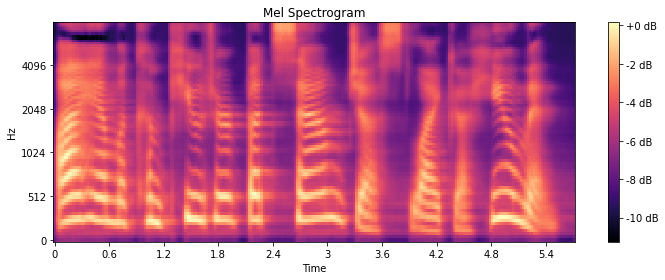

In [8]:
mel_np = mel[0].cpu().numpy()
plot_spectogram(mel_np, hparams.sampling_rate)

### Griffin-Lim Vocoder - Mel-spectogram to speech

In [ ]:
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)

mel_decompress = taco_stft.spectral_de_normalize(mel)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()

spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0].float(), taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 50)

### Play Waveform

In [ ]:
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate)

### Plot Waveform

In [14]:
def plot_waveform(waveform_np):
  time_axis = (1/hparams.sampling_rate) * np.arange(waveform_np.size)
  plt.figure(figsize=(10, 4))
  plt.plot(time_axis, waveform_np)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title('Waveform')
  plt.tight_layout()
  plt.show()

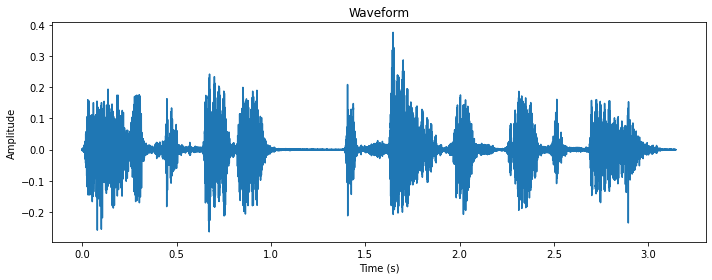

In [ ]:
waveform_np = waveform[0].data.cpu().numpy()
plot_waveform(waveform_np)

## Tactron2 Model + Waveglow Vocoder

### Text Input

In [ ]:
text = "I am a computer but sound just like a human."

### Tacotron2 Model - Text to Mel-spectogram

In [9]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### Waveglow Vocoder - Mel-spectogram to speech

Block diagram of the waveglow architecture

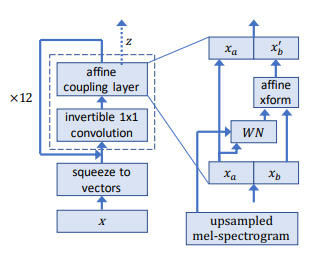

In [4]:
Image(filename='/content/waveglow_architecture.PNG')

Load pretrained WaveGlow model


In [10]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

### Run pipeline (model + vocoder)

Run the chained models:

In [11]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

### Play Waveform

In [12]:
Audio(audio_numpy, rate=rate)

We can definitely hear the improvement in the Waveglow vocoder output over the Griffin Lim vocoder output, which is much more natural.

### Plot Waveform

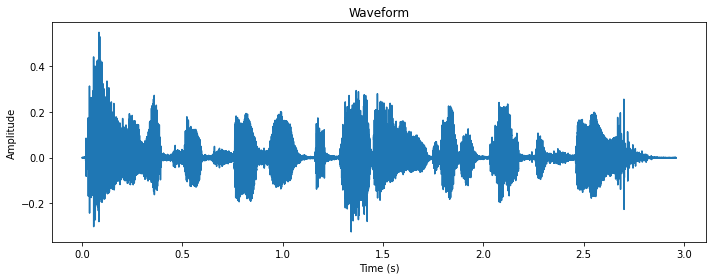

In [15]:
plot_waveform(audio_numpy)

The waveforms look similar but sound different.

## VITS end-to-end model (trained on LJspeech dataset)

imports

In [ ]:
!pip install TTS
# !git clone https://github.com/coqui-ai/TTS
# !pip install -e .[all,dev,notebooks]  # Select the relevant extras
!sudo apt-get install espeak-ng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
espeak-ng is already the newest version (1.50+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
from TTS.api import TTS
import IPython
from IPython.display import Audio

Input Text

In [ ]:
text = "I am a computer but sound just like a human."

List of Languages, datasets, models and vocoders

In [ ]:
models = TTS.list_models()
for model in models:
  print(model)

tts_models/multilingual/multi-dataset/your_tts
tts_models/bg/cv/vits
tts_models/cs/cv/vits
tts_models/da/cv/vits
tts_models/et/cv/vits
tts_models/ga/cv/vits
tts_models/en/ek1/tacotron2
tts_models/en/ljspeech/tacotron2-DDC
tts_models/en/ljspeech/tacotron2-DDC_ph
tts_models/en/ljspeech/glow-tts
tts_models/en/ljspeech/speedy-speech
tts_models/en/ljspeech/tacotron2-DCA
tts_models/en/ljspeech/vits
tts_models/en/ljspeech/vits--neon
tts_models/en/ljspeech/fast_pitch
tts_models/en/ljspeech/overflow
tts_models/en/ljspeech/neural_hmm
tts_models/en/vctk/vits
tts_models/en/vctk/fast_pitch
tts_models/en/sam/tacotron-DDC
tts_models/en/blizzard2013/capacitron-t2-c50
tts_models/en/blizzard2013/capacitron-t2-c150_v2
tts_models/es/mai/tacotron2-DDC
tts_models/es/css10/vits
tts_models/fr/mai/tacotron2-DDC
tts_models/fr/css10/vits
tts_models/uk/mai/glow-tts
tts_models/uk/mai/vits
tts_models/zh-CN/baker/tacotron2-DDC-GST
tts_models/nl/mai/tacotron2-DDC
tts_models/nl/css10/vits
tts_models/de/thorsten/tacotr

Block diagram of the Vits architecture

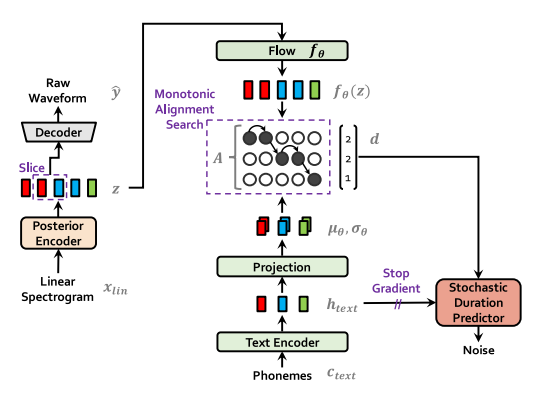

In [ ]:
Image(filename='/content/vits_architecture.PNG')

In [ ]:
model_name = 'tts_models/en/ljspeech/vits'
tts = TTS(model_name)

 > Downloading model to /root/.local/share/tts/tts_models--en--ljspeech--vits


100%|██████████| 146M/146M [00:10<00:00, 14.5MiB/s]


 > Model's license - apache 2.0
 > Check https://choosealicense.com/licenses/apache-2.0/ for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [ ]:
text = "I am a computer but sound just like a human"
wav = tts.tts(text)
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 2.8404881954193115
 > Real-time factor: 0.8046346956448589


The VITS model produces a high-quality, and a more natural-sounding speech

# Multi-Language TTS (seperate model for each langauge)

In [ ]:
# tts_models/el/cv/vits - Greek
# tts_models/hr/cv/vits - Croatian
# tts_models/lt/cv/vits - Lithuanian
# tts_models/lv/cv/vits - Latvian
# tts_models/mt/cv/vits - Maltese
# tts_models/pt/cv/vits - Portuguese
# tts_models/ro/cv/vits - Romanian
# tts_models/sk/cv/vits - Slovak
# tts_models/sl/cv/vits - Slovenian
# tts_models/sv/cv/vits - Swedish
# tts_models/bg/cv/vits - Bulgarian
# tts_models/cs/cv/vits - Czech
# tts_models/da/cv/vits - Danish
# tts_models/et/cv/vits - Estonian
# tts_models/ga/cv/vits - Irish
# tts_models/es/css10/vits - Spanish
# tts_models/fr/css10/vits - French
# tts_models/nl/css10/vits - Dutch
# tts_models/hu/css10/vits - Hungarian
# tts_models/fi/css10/vits - Finnish

## VITS end-to-end model

Spanish

In [31]:
model_name = 'tts_models/es/css10/vits'
tts = TTS(model_name)

 > Downloading model to /root/.local/share/tts/tts_models--es--css10--vits


100%|██████████| 101M/101M [00:06<00:00, 15.8MiB/s]


 > Model's license - bsd-3-clause
 > Check https://opensource.org/licenses for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.
 > initialization of language-embedding layers.


In [32]:
text = "Soy una computadora pero sueno como un humano"
wav = tts.tts(text)
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['Soy una computadora pero sueno como un humano']
 > Processing time: 0.5322051048278809
 > Real-time factor: 0.16426543339102426


French

In [33]:
model_name = 'tts_models/fr/css10/vits'
tts = TTS(model_name)

 > Downloading model to /root/.local/share/tts/tts_models--fr--css10--vits


100%|██████████| 101M/101M [00:14<00:00, 6.78MiB/s]


 > Model's license - bsd-3-clause
 > Check https://opensource.org/licenses for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.
 > initialization of language-embedding layers.


In [34]:
text = "Je suis un ordinateur mais je parle comme un humain"
wav = tts.tts(text)
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['Je suis un ordinateur mais je parle comme un humain']
 > Processing time: 1.4711413383483887
 > Real-time factor: 0.3983919545905626


Dutch

In [42]:
model_name = 'tts_models/nl/css10/vits'
tts = TTS(model_name)

 > Downloading model to /root/.local/share/tts/tts_models--nl--css10--vits


100%|██████████| 101M/101M [00:06<00:00, 15.3MiB/s] 


 > Model's license - bsd-3-clause
 > Check https://opensource.org/licenses for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.
 > initialization of language-embedding layers.


In [43]:
text = "Ik ben een computer, maar klink net als een mens"
wav = tts.tts(text)
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['Ik ben een computer, maar klink net als een mens']
 > Processing time: 0.5627918243408203
 > Real-time factor: 0.1676967530637174


# Multi-Speaker, Single-Language TTS

## VITS end-to-end model (trained on VCTK dataset with 108 speakers)

In [21]:
model_name = 'tts_models/en/vctk/vits'
tts = TTS(model_name)

 > Downloading model to /root/.local/share/tts/tts_models--en--vctk--vits


100%|██████████| 148M/148M [00:10<00:00, 13.5MiB/s]


 > Model's license - apache 2.0
 > Check https://choosealicense.com/licenses/apache-2.0/ for more info.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [29]:
print(len(tts.speakers)-1)

108


In [23]:
for speaker in tts.speakers:
  print(speaker)

ED

p225
p226
p227
p228
p229
p230
p231
p232
p233
p234
p236
p237
p238
p239
p240
p241
p243
p244
p245
p246
p247
p248
p249
p250
p251
p252
p253
p254
p255
p256
p257
p258
p259
p260
p261
p262
p263
p264
p265
p266
p267
p268
p269
p270
p271
p272
p273
p274
p275
p276
p277
p278
p279
p280
p281
p282
p283
p284
p285
p286
p287
p288
p292
p293
p294
p295
p297
p298
p299
p300
p301
p302
p303
p304
p305
p306
p307
p308
p310
p311
p312
p313
p314
p316
p317
p318
p323
p326
p329
p330
p333
p334
p335
p336
p339
p340
p341
p343
p345
p347
p351
p360
p361
p362
p363
p364
p374
p376


Results

In [24]:
text = "I am a computer but sound just like a human"
wav = tts.tts(text, speaker=tts.speakers[0])
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.5719618797302246
 > Real-time factor: 0.5640093635780307


In [25]:
wav = tts.tts(text, speaker=tts.speakers[1])
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.8861477375030518
 > Real-time factor: 0.599342252881345


In [26]:
wav = tts.tts(text, speaker=tts.speakers[2])
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.4577884674072266
 > Real-time factor: 0.586573644276083


In [27]:
wav = tts.tts(text, speaker=tts.speakers[3])
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 2.1882286071777344
 > Real-time factor: 0.8018220019321498


In [28]:
wav = tts.tts(text, speaker=tts.speakers[4])
IPython.display.display(Audio(wav, rate=22050))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 2.5423691272735596
 > Real-time factor: 0.9084009472449764


# Multi-Speaker, Multi-Language TTS (Single Model)

## VITS end-to-end model (Multi-speaker (6 speakers) Multi-language (3 languages) Multi-dataset model)

Get model

In [73]:
model_name = TTS.list_models()[0]
print(model_name)

tts_models/multilingual/multi-dataset/your_tts


In [74]:
tts = TTS(model_name)

 > tts_models/multilingual/multi-dataset/your_tts is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model fully restored. 
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:64
 | > log_func:np.log10
 | > min_level_db:-

Languages

In [75]:
for language in tts.languages:
  print(language)

en
fr-fr
pt-br


Speakers

In [76]:
for speaker in tts.speakers:
  print(speaker)

female-en-5
female-en-5

female-pt-4

male-en-2
male-en-2

male-pt-3



### Multi-Speaker

In [77]:
wav = tts.tts(text, speaker=tts.speakers[0], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 0.7787988185882568
 > Real-time factor: 0.19158642523696354


In [78]:
wav = tts.tts(text, speaker=tts.speakers[1], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 0.9280838966369629
 > Real-time factor: 0.25545937149379655


In [79]:
wav = tts.tts(text, speaker=tts.speakers[2], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.1866252422332764
 > Real-time factor: 0.31821540419235084


In [80]:
wav = tts.tts(text, speaker=tts.speakers[3], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 0.9902386665344238
 > Real-time factor: 0.31406237441624607


In [81]:
wav = tts.tts(text, speaker=tts.speakers[4], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.2376797199249268
 > Real-time factor: 0.40275942724533903


In [82]:
wav = tts.tts(text, speaker=tts.speakers[5], language=tts.languages[0])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human']
 > Processing time: 1.9150457382202148
 > Real-time factor: 0.5565375583319427


### Multi-Language

In [83]:
text = "Je suis un ordinateur mais je parle comme un humain."
wav = tts.tts(text, speaker=tts.speakers[1], language=tts.languages[1])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Je suis un ordinateur mais je parle comme un humain.']
 > Processing time: 2.3235864639282227
 > Real-time factor: 0.7933036749498883


In [84]:
text = "Je suis un ordinateur mais je parle comme un humain."
wav = tts.tts(text, speaker=tts.speakers[4], language=tts.languages[1])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Je suis un ordinateur mais je parle comme un humain.']
 > Processing time: 1.7590396404266357
 > Real-time factor: 0.6955475051113625


In [85]:
text = "Eu sou um computador, mas pareço um ser humano."
wav = tts.tts(text, speaker=tts.speakers[1], language=tts.languages[2])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Eu sou um computador, mas pareço um ser humano.']
 > Processing time: 2.519638776779175
 > Real-time factor: 0.4935629337471449


In [86]:
text = "Eu sou um computador, mas pareço um ser humano."
wav = tts.tts(text, speaker=tts.speakers[4], language=tts.languages[2])
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Eu sou um computador, mas pareço um ser humano.']
 > Processing time: 1.9194190502166748
 > Real-time factor: 0.4361324813034935


# Zero Shot Text-to-speech

Oiriginal Recorded Male

In [87]:
wav_path = "/content/elad.wav"
Audio(wav_path)

Recorded Male speaking English

In [88]:
text = "I am a computer but sound just like a human."
wav = tts.tts(text, language=tts.languages[0], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human.']
 > Processing time: 3.755845785140991
 > Real-time factor: 0.9737738618462513


Recorded Male speaking French

In [89]:
text = "Je suis un ordinateur mais je parle comme un humain."
wav = tts.tts(text, language=tts.languages[1], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Je suis un ordinateur mais je parle comme un humain.']
 > Processing time: 2.2171294689178467
 > Real-time factor: 0.7214869732892439


Recorded Male speakin Portuguese

In [90]:
text = "Eu sou um computador, mas pareço um ser humano."
wav = tts.tts(text, language=tts.languages[2], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Eu sou um computador, mas pareço um ser humano.']
 > Processing time: 3.7890117168426514
 > Real-time factor: 0.8053159865765465


Oiriginal Recorded Female

In [91]:
wav_path = "/content/adi.wav"
Audio(wav_path)

Recorded Female speaking English

In [92]:
text = "I am a computer but sound just like a human."
wav = tts.tts(text, language=tts.languages[0], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['I am a computer but sound just like a human.']
 > Processing time: 3.5429611206054688
 > Real-time factor: 0.8417584035650912


Recorded Female speaking French

In [93]:
text = "Je suis un ordinateur mais je parle comme un humain."
wav = tts.tts(text, language=tts.languages[1], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Je suis un ordinateur mais je parle comme un humain.']
 > Processing time: 2.31911301612854
 > Real-time factor: 0.7102949513410536


Recorded Female speakin Portuguese

In [94]:
text = "Eu sou um computador, mas pareço um ser humano."
wav = tts.tts(text, language=tts.languages[2], speaker_wav=wav_path)
IPython.display.display(Audio(wav, rate=16000))

 > Text splitted to sentences.
['Eu sou um computador, mas pareço um ser humano.']
 > Processing time: 2.5082828998565674
 > Real-time factor: 0.518990875203097


In [ ]:
from google.colab import runtime
runtime.unassign()